### Notebook to be used to test that ATCamera, ATHeaderService and ATArchiver are online and working

In [1]:
import numpy as np
from lsst.ts import salobj
import wget
import asyncio
from astropy.io import fits
from astropy import time as astropytime

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.afw.display as afwDisplay

afwDisplay.setDefaultBackend('matplotlib')
import time
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.geom

from scipy.signal import medfilt
import copy
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage

import os
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')

In [2]:
#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

In [3]:
# Want to display in firefly?
afwDisplay.setDefaultBackend('firefly')
os.environ['FIREFLY_HTML'] = "slate.html"
os.environ['FIREFLY_URL'] = 'http://139.229.170.210:8080/firefly/'

In [4]:
# # Setup the butler
#accs_images = True
accs_images = False
if accs_images:
    repo = os.path.join("/home/saluser/ingest/accs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
else:
    #repo = os.path.join("/home/saluser/ingest/dmcs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    repo = os.path.join("/mnt/dmcs/oods_butler_repo/repo/")
    butler = dafPersist.Butler(repo) #
    #butler = dafPersist.Butler(repo, mapper="lsst.obs.lsst.auxTel.AuxTelMapper")
#test   
#raw = butler.get("raw", visit=2019111300004)
#image = raw.getImage().array

In [5]:
# Load the LATISS class
from lsst.ts.standardscripts.auxtel.latiss import LATISS

latiss = LATISS()

await latiss.start_task 

2020-01-29 01:11:18,322 ATArchiver   INFO     Read historical data in 8.39 sec
2020-01-29 01:11:18,647 ATHeaderService INFO     Read historical data in 8.71 sec
2020-01-29 01:11:18,863 ATCamera     INFO     Read historical data in 8.93 sec
2020-01-29 01:11:19,215 ATSpectrograph INFO     Read historical data in 9.28 sec


[None, None, None, None]

In [6]:
# Load the ATTCS class
from lsst.ts.standardscripts.auxtel.attcs import ATTCS

attcs = ATTCS(domain=latiss.domain)

await attcs.start_task 

2020-01-29 01:11:40,021 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 18 messages
2020-01-29 01:11:40,048 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 17 messages
2020-01-29 01:11:40,069 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 17 messages
2020-01-29 01:11:40,090 ATDomeTrajectory INFO     Read historical data in 0.07 sec
2020-01-29 01:11:40,424 ATHexapod    INFO     Read historical data in 0.41 sec
2020-01-29 01:11:41,173 ATPneumatics INFO     Read historical data in 1.16 sec
2020-01-29 01:11:42,214 ATAOS        INFO     Read historical data in 2.20 sec
2020-01-29 01:11:43,148 ATDome       INFO     Read historical data in 3.13 sec
2020-01-29 01:11:44,129 ATMCS        INFO     Read historical data in 4.12 sec
2020-01-29 01:11:46,970 ATPtg        INFO     Read historical data in 6.96 sec
2020-01-29 01:11:47,817 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory

[None, None, None, None, None, None, None]

2020-01-29 01:11:47,988 ATDome       WARNING  RemoteTelemetry(ATDome, 0, position) falling behind; read 19 messages
2020-01-29 01:11:48,063 ATMCS        WARNING  RemoteEvent(ATMCS, 0, target) falling behind; read 54 messages
2020-01-29 01:12:29,040 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages
2020-01-29 01:12:45,617 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 13 messages
2020-01-29 01:13:10,641 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages
2020-01-29 01:13:19,222 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages
2020-01-29 01:13:27,599 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages


## Perform State Transitions

In [705]:
# Get state of CSC
salobj.State((attcs.athexapod.evt_summaryState.get()).summaryState)

<State.STANDBY: 5>

In [ ]:
# State transitions
#await salobj.set_summary_state(latiss.atspec, salobj.State.OFFLINE, timeout=60, settingsToApply='current')

In [ ]:
#Setup LATISS
#await latiss.atspec.cmd_homeLinearStage.start(timeout=90)
#await latiss.setup_atspec(filter='blank_bk7_wg05', grating='empty_1', linear_stage=60)

In [10]:
# Declare target name
target_name='HD32309'

In [11]:
logger = salobj.Controller("Script", index=1)
logger.evt_logMessage.set_put(message="Test Starting for target: {}".format(target_name))

True

2020-01-29 01:16:30,487 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 13 messages
2020-01-29 01:16:30,502 ATMCS        WARNING  RemoteEvent(ATMCS, 0, target) falling behind; read 13 messages
2020-01-29 01:16:30,538 Script       INFO     Read historical data in 0.01 sec


## Declare focus offsets

In [9]:
dz = 0.8
offset_intra = {'m1': 0.0,
          'm2': 0.0,
          'x': 0.0,
          'y': 0.0,
          'z': -dz,
          'u': 0.0,
          'v': 0.0
          }
offset_extra = {'m1': 0.0,
          'm2': 0.0,
          'x': 0.0,
          'y': 0.0,
          'z': 2*dz,
          'u': 0.0,
          'v': 0.0
          }

## Declare grating, filters, expTime, group_id, image_type

In [661]:
filter='blank_bk7_wg05'
grating='ronchi90lpmm'

## Move to intra-focal image (-z on hexapod)

In [662]:
# Move intra-focus
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_offset.set_start(**offset_intra)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

### Take an exposure

In [663]:
expTime=45.0 # seconds
group_id=astropytime.Time.now().tai.isot

intra_endReadout = await latiss.take_image(exptime=expTime, shutter=True,image_type='ENGTEST',
                                           group_id=group_id, filter=filter, grating=grating) # 'blank_bk7_wg05' KPNO_406_828nm'  'KPNO_1111_436nm' 'KPNO_373A_677nm' 'ronchi170lpmm'


In [664]:
# OODS event not in currently deployed XML (4.4.1)
#test= await ATArchiver.evt_imageInOODS.next(flush=False, timeout=30) 

In [665]:
logger.evt_logMessage.set_put(message="CCS intraImage for target: {}".format(intra_endReadout.imageName))

True

## Move to extra-focal image  (+z on hexapod)

In [666]:
# Move extra-focus
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_offset.set_start(**offset_extra)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

### Take an exposure

In [667]:
#First flush events that we want to listen to
extra_endReadout = await latiss.take_image(exptime=expTime, shutter=True,image_type='ENGTEST',
                                           group_id=group_id, filter=filter, grating=grating)# 'blank_bk7_wg05' KPNO_406_828nm'  'KPNO_1111_436nm' 'KPNO_373A_677nm' 'ronchi170lpmm'


2020-01-29 05:58:34,367 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages


In [668]:
# OODS event not in currently deployed XML (4.4.1)
#test= await ATArchiver.evt_imageInOODS.next(flush=False, timeout=30) 

In [669]:
logger.evt_logMessage.set_put(message="CCS extraImage for target: {}".format(extra_endReadout.imageName))

True

## Move Hexapod back to focus Position

In [670]:
#Move the hexapod back
# move back to zero offset
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_offset.set_start(**offset_intra)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

In [671]:
#First flush events that we want to listen to
focus_endReadout = await latiss.take_image(exptime=expTime/6, shutter=True,image_type='ENGTEST',
                                           group_id=group_id, filter=filter, grating=grating)# 'blank_bk7_wg05' KPNO_406_828nm'  'KPNO_1111_436nm' 'KPNO_373A_677nm' 'ronchi170lpmm'


In [672]:
# parse out visitID from filename - this is highly annoying
tmp=focus_endReadout.imageName.split('_')
prefix=tmp[2] # dayobs without the dashes

# Don't remember why I used int here... whitespace? 
# surely fixable but bigger fish.
suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
focus_visitID = int((prefix+suffix))
logger.evt_logMessage.set_put(message="focusImage visitID for target: {}".format(focus_visitID))
print("focusImage visitID for target: {}".format(focus_visitID))

focusImage visitID for target: 2020012800335


## Reduce Intra Data

In [673]:
# parse out visitID from filename - this is highly annoying
tmp=intra_endReadout.imageName.split('_')
prefix=tmp[2] # dayobs without the dashes

# Don't remember why I used int here... whitespace? 
# surely fixable but bigger fish.
suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
intra_visitID = int((prefix+suffix))
logger.evt_logMessage.set_put(message="intraImage visitID for target: {}".format(intra_visitID))

True

In [674]:
## Load file from Butler
import importlib
import utils.processExposure 
importlib.reload(utils.processExposure)
from utils.processExposure import processExposure

In [675]:
if False:
    print('MANUAL OVERRIDE ON intra_visitID')
    intra_visitID = 2020012700579
    print(intra_visitID)

# Grab image from butler, but have to redefine butler after each image
butler = dafPersist.Butler(repo)
exposure = butler.get("raw", visit=intra_visitID)
#image = raw.getImage().array

# do ISR correction
intra_isr_corr_exposure = processExposure(exposure, repo=repo, bias=None, flat=False, defects=False )
#intra_isr_corr_exposure = exposure

2020-01-29 05:58:59,802 lsst.obs.lsst.translators.latiss WARNING  AT_O_20200128_000333: Dark time less than exposure time. Setting dark time to the exposure time.
/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/pex_config/19.0.0+2/python/lsst/pex/config/config.py:1289: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)


Time to perform image ISR was 2.678718 [s]


In [676]:
#Cosmic Ray Repair
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
imCharConfig = CharacterizeImageTask.ConfigClass()
imCharConfig.doMeasurePsf = False
imCharConfig.doApCorr = False
imCharConfig.doDeblend = False
imCharTask = CharacterizeImageTask(config=imCharConfig)
intra_crr_isr_corr_exposure = imCharTask.run(intra_isr_corr_exposure).exposure

/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/meas_algorithms/19.0.0-2-g3d9e4fb2+9/python/lsst/meas/algorithms/subtractBackground.py:325: FutureWarning: Call to deprecated method __init__. (Overloads that take a ``style`` parameter are deprecated; the style must be passed to `Background.getImageF` instead. To be removed after 20.0.0.)
  self.config.statisticsProperty)
/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/meas_algorithms/19.0.0-2-g3d9e4fb2+9/python/lsst/meas/algorithms/subtractBackground.py:239: FutureWarning: Call to deprecated method getImageF(). (Zero-argument overload is deprecated; use one that takes an ``interpStyle`` instead. To be removed after 20.0.0.)
  maskedImage -= fitBg.getImageF()
/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/meas_algorithms/19.0.0-2-g3d9e4fb2+9/python/lsst/meas/algorithms/subtractBackground.py:240: FutureWarning: Passing Background objects to BackgroundList is deprecated; use a (Background

In [677]:
if False: # display the image in firefly
    plt.close('all')
    disp = afwDisplay.Display(2, reopenPlot=True)
    disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'zscale')
    disp.mtv(intra_crr_isr_corr_exposure, title='visit = {}'.format(intra_visitID))
    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)

2020-01-29 05:59:12,366 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
2020-01-29 05:59:12,457 ATMCS        WARNING  RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
2020-01-29 05:59:12,545 ATPtg        WARNING  RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 69 messages
2020-01-29 05:59:12,606 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 14 messages
2020-01-29 05:59:12,620 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 14 messages
2020-01-29 05:59:12,635 ATDome       WARNING  RemoteTelemetry(ATDome, 0, position) falling behind; read 68 messages
2020-01-29 05:59:12,693 ATAOS        WARNING  RemoteEvent(ATAOS, 0, detailedState) falling behind; read 14 messages
2020-01-29 05:59:12,706 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 14 messages
2020-01-29 05:59:12,719 ATArchiver   WARNING  R

## Reduce Extra Data

In [681]:
# parse out visitID from filename - this is highly annoying
tmp=extra_endReadout.imageName.split('_')
prefix=tmp[2] # dayobs without the dashes

# Don't remember why I used int here... whitespace? 
# surely fixable but bigger fish.
suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
extra_visitID = int((prefix+suffix))

In [682]:
## Load file from Butler
import importlib
import utils.processExposure 
importlib.reload(utils.processExposure)
from utils.processExposure import processExposure

In [683]:
if False:
    print('MANUAL OVERRIDE ON extra_visitID')
    extra_visitID = 2020012700580
    print(extra_visitID)

# Grab image from butler, but have to redefine butler after each image
butler = dafPersist.Butler(repo)
exposure = butler.get("raw", visit=extra_visitID)
#image = raw.getImage().array

# do ISR correction
extra_isr_corr_exposure = processExposure(exposure, repo=repo, bias=None, flat=False, defects=False )
#extra_isr_corr_exposure = exposure

2020-01-29 05:59:25,976 lsst.obs.lsst.translators.latiss WARNING  AT_O_20200128_000334: Dark time less than exposure time. Setting dark time to the exposure time.
/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/pex_config/19.0.0+2/python/lsst/pex/config/config.py:1289: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)


Time to perform image ISR was 2.659578 [s]


In [684]:
#Cosmic Ray Repair
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
imCharConfig = CharacterizeImageTask.ConfigClass()
imCharConfig.doMeasurePsf = False
imCharConfig.doApCorr = False
imCharConfig.doDeblend = False
imCharTask = CharacterizeImageTask(config=imCharConfig)
extra_crr_isr_corr_exposure = imCharTask.run(extra_isr_corr_exposure).exposure

/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/meas_algorithms/19.0.0-2-g3d9e4fb2+9/python/lsst/meas/algorithms/subtractBackground.py:325: FutureWarning: Call to deprecated method __init__. (Overloads that take a ``style`` parameter are deprecated; the style must be passed to `Background.getImageF` instead. To be removed after 20.0.0.)
  self.config.statisticsProperty)
/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/meas_algorithms/19.0.0-2-g3d9e4fb2+9/python/lsst/meas/algorithms/subtractBackground.py:239: FutureWarning: Call to deprecated method getImageF(). (Zero-argument overload is deprecated; use one that takes an ``interpStyle`` instead. To be removed after 20.0.0.)
  maskedImage -= fitBg.getImageF()
/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/meas_algorithms/19.0.0-2-g3d9e4fb2+9/python/lsst/meas/algorithms/subtractBackground.py:240: FutureWarning: Passing Background objects to BackgroundList is deprecated; use a (Background

In [702]:
if False: # display the image in firefly
    plt.close('all')
    disp = afwDisplay.Display(2, reopenPlot=True)
    disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'zscale')
    disp.mtv(extra_isr_corr_exposure, title='visit = {}'.format(extra_visitID))
    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)

2020-01-29 06:07:58,287 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 15 messages
2020-01-29 06:07:58,337 ATMCS        WARNING  RemoteEvent(ATMCS, 0, target) falling behind; read 92 messages
2020-01-29 06:11:26,052 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages
2020-01-29 06:11:34,321 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 15 messages
2020-01-29 06:12:15,835 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 15 messages
2020-01-29 06:16:25,545 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 15 messages
2020-01-29 06:18:00,933 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 10 messages
2020-01-29 06:18:29,743 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 12 messages


In [686]:
extra_visitID

2020012800334

In [687]:
# # Look at the summed images
# coadd=copy.deepcopy(extra_isr_corr_exposure)
# coadd.image+=intra_isr_corr_exposure.image

# if False: # display the image in firefly
#     plt.close('all')
#     disp = afwDisplay.Display(2, reopenPlot=True)
#     disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
#     disp.setImageColormap('gray')
#     disp.scale('linear', 'zscale')
#     disp.mtv(coadd, title='visit = {}'.format(extra_visitID))
#     #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)

In [688]:
# side=400
# intra_center = lsst.geom.Point2D(2039,1967)
# bbox_intra= lsst.geom.Box2I.makeCenteredBox(intra_center, lsst.geom.Extent2I(side, side))


In [689]:
intra_exp = intra_crr_isr_corr_exposure.image.array
extra_exp = extra_isr_corr_exposure.image.array

2020-01-29 05:59:38,853 ATMCS        WARNING  RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 14 messages
2020-01-29 05:59:38,872 ATPtg        WARNING  RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 69 messages
2020-01-29 05:59:38,952 ATHexapod    WARNING  RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 14 messages
2020-01-29 05:59:38,967 ATPneumatics WARNING  RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 14 messages
2020-01-29 05:59:38,982 ATDome       WARNING  RemoteEvent(ATDome, 0, heartbeat) falling behind; read 14 messages
2020-01-29 05:59:39,008 ATMCS        WARNING  RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 14 messages
2020-01-29 05:59:39,026 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 14 messages
2020-01-29 05:59:39,044 ATPneumatics WARNING  RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 14 messages
2020-01-29 05:59:39,071 ATMC

### Grab centroid of images

In [690]:
# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=400
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    cenx=2033 #round(im_shape[0]/2)
    ceny=1952 # round(im_shape[1]/2)
    
side=140 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

99 9
Creating stamps of centroid [y,x] = [2389,2286] with a side length of 140 pixels


In [691]:
#plt.imshow(extra_square)

2020-01-29 06:00:10,787 ATMCS        WARNING  RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 28 messages
2020-01-29 06:00:10,830 ATPtg        WARNING  RemoteEvent(ATPtg, 0, mountDataWarning) falling behind; read 21 messages
2020-01-29 06:00:10,864 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
2020-01-29 06:00:10,973 ATDome       WARNING  RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
2020-01-29 06:00:11,081 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 28 messages
2020-01-29 06:00:11,115 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 28 messages
2020-01-29 06:00:11,162 ATAOS        WARNING  RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 28 messages
2020-01-29 06:00:11,204 ATHexapod    WARNING  RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 28 messages
2020-01-29 06:00:11,236 ATArchi

In [692]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

2020-01-29 06:00:11,383 ATMCS        WARNING  RemoteTelemetry(ATMCS, 0, measuredTorque) falling behind; read 29 messages


## Load instrument profile from "/home/saluser/develop/cwfs/data/auxtel"
### Make sure pixelSize and offset are correct for the dataset! 
### You *must* modify the file and not the loaded object!!!

In [693]:
# Declare instrument
inst=Instrument('auxtel_LATISS',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 10e-6 # no binning for LATISS
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)

Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :32.800000000000004 [mm] at the focus
pixelSize should be: 1e-05


In [694]:
#algo.numTerms = 11
#algo.ZTerms = np.arange(algo.numTerms) + 1

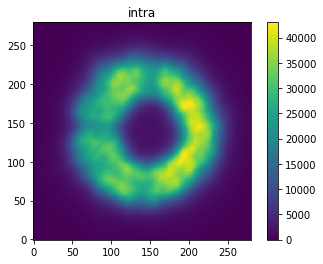

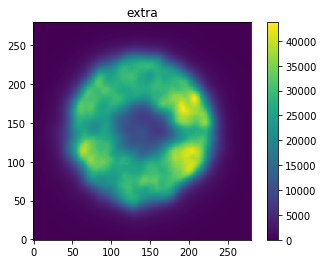

Intra-focal visitID: 2020012800333
Extra-focal visitID: 2020012800334
In-focus visitID: 2020012800335


2020-01-29 06:00:11,982 ATMCS        WARNING  RemoteTelemetry(ATMCS, 0, measuredMotorVelocity) falling behind; read 29 messages
2020-01-29 06:00:12,014 ATPneumatics WARNING  RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 29 messages
2020-01-29 06:00:12,047 ATPtg        WARNING  RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
2020-01-29 06:00:12,183 ATPneumatics WARNING  RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 29 messages
2020-01-29 06:00:12,224 ATDome       WARNING  RemoteEvent(ATDome, 0, heartbeat) falling behind; read 29 messages
2020-01-29 06:00:12,271 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 29 messages
2020-01-29 06:00:12,306 ATPneumatics WARNING  RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 29 messages
2020-01-29 06:00:12,341 ATPtg        WARNING  RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
2020-

In [695]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Intra-focal visitID: {}'.format(intra_visitID))
print('Extra-focal visitID: {}'.format(extra_visitID))
print('In-focus visitID: {}'.format(focus_visitID))

In [696]:
# Calculate zernikes and wavefront
# Note that this will change I1 and I2!
# if you ever want to rerun this with different parameters you have to reload I1 and I2!
start_time=time.time()
algo.runIt(inst,I1,I2,'onAxis')
end_time=time.time()
print('time to run fitting is {} [s]'.format(end_time-start_time))

time to run fitting is 63.92910647392273 [s]


In [697]:
#print zernikes
print(algo.zer4UpNm)

[-15.94445337 -40.07352733  76.68641719 -24.26414116  68.8207868
  12.18719059 -45.47491119  25.08825231  -5.64493419  -3.73585005
   4.67523459  -3.10565516  -4.05235379   5.31329179   0.63187167
   0.11871208   8.09148282   9.57367488  -8.00344236]


2020-01-29 06:01:39,715 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 64 messages
2020-01-29 06:01:39,786 ATMCS        WARNING  RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
2020-01-29 06:01:39,889 ATPtg        WARNING  RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
2020-01-29 06:01:39,993 ATDome       WARNING  RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
2020-01-29 06:01:40,119 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 64 messages
2020-01-29 06:01:40,184 ATAOS        WARNING  RemoteEvent(ATAOS, 0, detailedState) falling behind; read 79 messages
2020-01-29 06:01:40,260 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 64 messages
2020-01-29 06:01:40,325 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 65 messages
2020-01-29 06:01:40,392 ATHexapod    W

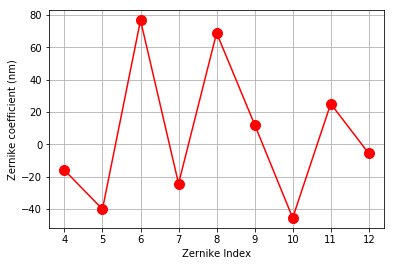

In [698]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

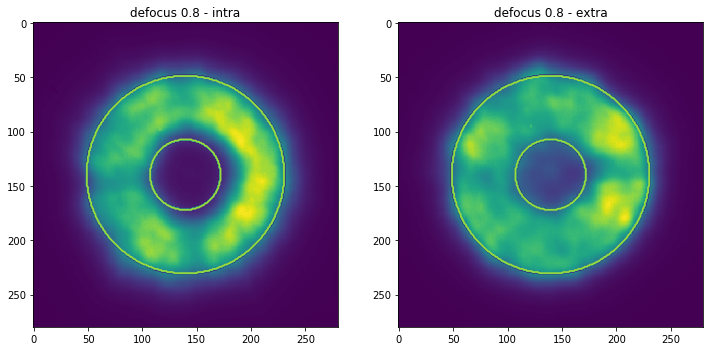

In [699]:
fig1 = plt.figure(1, figsize=(12,8))
ax11 = fig1.add_subplot(121)
ax11.set_title("defocus 0.8 - intra")
ax11.imshow(I1.image0)
ax11.contour(algo.pMask) 
ax12 = fig1.add_subplot(122)
ax12.set_title("defocus 0.8 - extra")
ax12.imshow(I2.image0)
ax12.contour(algo.pMask) 

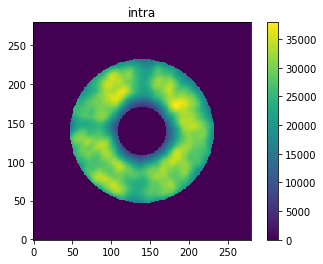

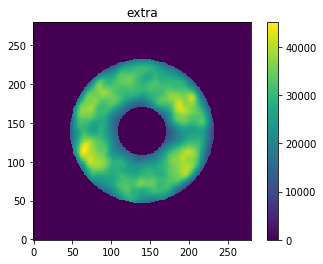

2020-01-29 06:01:41,733 ATAOS        WARNING  RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 10 messages
2020-01-29 06:01:41,758 ATDomeTrajectory WARNING  RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
2020-01-29 06:01:41,893 ATPtg        WARNING  RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
2020-01-29 06:01:42,072 ATMCS        WARNING  RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 66 messages
2020-01-29 06:01:42,143 ATAOS        WARNING  RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 10 messages
2020-01-29 06:01:42,163 ATDome       WARNING  RemoteEvent(ATDome, 0, heartbeat) falling behind; read 66 messages
2020-01-29 06:01:42,230 ATPtg        WARNING  RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 14 messages
2020-01-29 06:01:42,295 ATMCS        WARNING  RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 67 messages
2020-01-29 06:01:42,367 ATPneumatics

In [700]:
# Plot images with masks to check mapping is correct
# I think these plot residuals, but I1.image0 plots the original image
plots.plotImage(I1.image,'intra')#, mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')#, mask=algo.pMask)

In [ ]:
plots.plotImage(algo.Wconverge,'Final wavefront')

In [ ]:
#plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

In [ ]:
# Look at estimated wavefront and residual of wavefront that is not well fit
nanMask = np.ones(I1.image.shape)
nanMask[I1.pMask==0] = np.nan
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(algo.Wconverge*nanMask, origin='lower')
ax[0].set_title('Final WF = estimated + residual')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(algo.West*nanMask, origin='lower')
ax[1].set_title('residual wavefront')
fig.colorbar(img, ax=ax[1])

In [ ]:
# Plot the residuals at each image - ideally they would be a constant
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(I1.image, origin='lower')
ax[0].set_title('Intra residual image')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(I2.image, origin='lower')
ax[1].set_title('Extra residual image')
fig.colorbar(img, ax=ax[1])

In [ ]:
# Only here for me to debug, should be up top with other declarations
import importlib
import utils.findNarrowbandRonchiPeaks
importlib.reload(utils.findNarrowbandRonchiPeaks)
from utils.findNarrowbandRonchiPeaks import findNarrowbandRonchiPeaks

import utils.fitExposure
importlib.reload(utils.fitExposure)
from utils.fitExposure import fit2DGaussian

import utils.calc_CofM
importlib.reload(utils.calc_CofM)
from utils.calc_CofM import calc_CofM

import utils.calc_encircled_energy
importlib.reload(utils.calc_encircled_energy)
from utils.calc_encircled_energy import calc_encircled_energy

In [ ]:
# Source detection libraries
from lsst.meas.algorithms.detection import SourceDetectionTask
import lsst.afw.table as afwTable

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10  # detection threshold after smoothing
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

## Fit a gaussian

In [ ]:
# Declare approximation of where the zero-order star is
zeroth_order_estimate = lsst.geom.Point2D(1700,1960)
zeroth_order_estimate = lsst.geom.Point2D(1650,1930)
zeroth_order_estimate = lsst.geom.Point2D(2100,2100)

fit_data=[]

for index, img_name in enumerate(image_list):
    # parse out visitID from filename - this is highly annoying
    print('Processing file {} of {}, filename={}'.format(index,len(image_list), img_name))
    tmp=img_name.split('_')
    prefix=tmp[2] # dayobs without the dashes
    # Don't remember why I used int here... whitespace? 
    # surely fixable but bigger fish.
    suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
    visitID = int((prefix+suffix))
    dataId1 = {'visit': visitID}
    #multi_file_dataset[i]['visitID']=visitID
    
    #exposure = butler.get('raw', **dataId1)
    exposure = await grabATImage(visitID, repo, timeout = 40, poll_freq_hz=2)
    # do ISR correction
    isr_corr_exposure = processExposure(exposure, repo=repo, bias=None, defects=None)
    
    if False: # display the image in firefly
        plt.close('all')
        disp = afwDisplay.Display(2, reopenPlot=True)
        disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
        disp.setImageColormap('gray')
        disp.scale('linear', 'zscale')
        disp.mtv(isr_corr_exposure, title='visit = {}'.format(visit_int))
        cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)
    
    # Find all sources in the image
    tab = afwTable.SourceTable.make(schema)
    result = sourceDetectionTask.run(tab, isr_corr_exposure, sigma=2.1)
    
    # Find the correct sources
    zeroth_order_star_BBox= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(200,200)) 
    # wavelength solution is bad for the fiberSpectrograph, but close enough for this to work
    # can use the monochromator wavelength which is better, but that's not the correct way in the long run

    dispersion = (1/0.6358) # pixels/nm
    spectral_position_angle=0.0107 # radians clockwise from top

    # Find 0th and +/- 1 order peaks 
    sources = result.sources
    center_source, peak1, peak2 = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)
    
    # Fit peaks
    # zeroth order
    # variables names are weird here because I can't think of a clever way to have -1 and +1 as variable names
    
    bbox0 = lsst.geom.Box2I.makeCenteredBox(center_source.getFootprint().getCentroid(), lsst.geom.Extent2I(100,100)) 
    peak0_subim = isr_corr_exposure.subset(bbox0)
    p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)
    p0_x_CofM, p0_y_CofM = calc_CofM(peak0_subim) # 2167,3372

    # Calculate EE and CofM
    p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=False) 
    fit_data.append(p0_EE_rad80_pix)

#     # offset to test
#     bbox1 = lsst.geom.Box2I.makeCenteredBox(peak1.getFootprint().getCentroid(), lsst.geom.Extent2I(50,50)) 
#     peak1_subim = isr_corr_exposure.subset(bbox1)
#     p1, x1 , y1 = fit2DGaussian(peak1_subim, plot=True)
#     p1_x_CofM, p1_y_CofM = calc_CofM(peak1_subim) # 2167,3372

#     # Calculate EE and CofM
#     p1_EE_rad50_pix, p1_EE_rad67_pix, p1_EE_rad80_pix = calc_encircled_energy(peak1_subim, plot=False) 
    
#     fit_data.append(p1_EE_rad80_pix)
#     bbox2 = lsst.geom.Box2I.makeCenteredBox(peak2.getFootprint().getCentroid(), lsst.geom.Extent2I(50,50)) 
#     peak2_subim = isr_corr_exposure.subset(bbox2)
#     p2, x2 , y2 = fit2DGaussian(peak2_subim, plot=False)
#     p2_x_CofM, p2_y_CofM = calc_CofM(peak2_subim) # 2167,3372

#     # Calculate EE and CofM
#     p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=False) 
#     p1_EE_rad50_pix, p1_EE_rad67_pix, p1_EE_rad80_pix = calc_encircled_energy(peak1_subim, plot=False) 
#     p2_EE_rad50_pix, p2_EE_rad67_pix, p2_EE_rad80_pix = calc_encircled_energy(peak2_subim, plot=False) 
